In [8]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import random
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16
import seaborn as sns
from sklearn import preprocessing
import joblib
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report


# Creating static and local variables
SIZE = 128
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS = 3
n_classes = 4
EPOCHS = 50
BATCH_SIZE = 32
input_shape = (SIZE, SIZE, CHANNELS)



In [9]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [10]:
#--------------------Training
def training(path) : 
    # loading data from local directory -> basic method. here labels are folder name, means each variety of data stored in particular folder.
    train_images = []       # training dataset stored here...(numpy array form of images)
    train_labels = []     # labels will be stored here 
    
    '''here we are using glob for accessing directories'''
    path = path + '\*'
    for directory_path in glob.glob(path) :   
        label = directory_path.split('\\')[-1]       # taking labels from folders
        # print(label)    # extracting label from directory path
        
        '''now we are entering into each folder and reading images from it and at a same 
        time we are also storing the label.'''
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) :    
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    # read color image 
            img = cv2.merge((img, img, img))      # we have grey scale image, here we are converting it into 3 channel image
            img = cv2.resize(img, (SIZE, SIZE))        # resize the image
            
            '''actually cv2 read image in BGR channel ordering, in color image we have 3 channels
            RGB so here the channel order is different nothing special!. it doesnt affect on model.
            In reality we can arrange them in any order we like.'''
            # cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            train_images.append(img)
            train_labels.append(label)
    
    # Shuffling the list to avoid the some kind of bias.
    train_data = list(zip(train_images, train_labels))
    '''Seed function is used to save the state of a random function, so that it can generate          
        same random numbers on multiple executions of the code on the same machine or on 
        different machines (for a specific seed value).'''
    random.seed(SEED_TRAINING)   
    random.shuffle(train_data)
    train_images, train_labels = zip(*train_data)   # it will unzip the ziped iterators, it will return tuple
    
    # converting tuples to numpy array.
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    
    # let's normalize our pixel values 
    train_images = train_images / 255.0
    return train_images, train_labels

def testing(path) : 
    test_images = []
    test_labels = []
    
    path = path + '\*'
    for directory_path in glob.glob(path) : 
        labels = directory_path.split('\\')[-1]
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) : 
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.merge((img, img, img)) 
            img = cv2.resize(img, (SIZE, SIZE))
            test_images.append(img)
            test_labels.append(labels)
            
    # Shuffling testing data
    test_data = list(zip(test_images, test_labels))
    random.seed(SEED_TESTING)
    random.shuffle(test_data)
    test_images, test_labels = zip(*test_data)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    # let's normalize our pixel values
    test_images = test_images / 255.0
    return test_images, test_labels



In [11]:
# preprocessing training and testing images
X_test, y_test_labels = training(r'C:\Users\Arun\Downloads\dataset3\Testing')
X_train, y_train_labels = training(r'C:\Users\Arun\Downloads\dataset3\Training')



In [12]:
# encoding labels from text to integer
le = preprocessing.LabelEncoder()
le.fit(y_train_labels)
train_label_encoded = le.transform(y_train_labels)
le.fit(y_test_labels)
test_label_encoded = le.transform(y_test_labels)



In [13]:
# extracting original labels, later we will need it.
labels = dict(zip(le.classes_,range(len(le.classes_))))
print(labels)



{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [14]:
# aliasing for better understanding
y_train, y_test = train_label_encoded, test_label_encoded



In [9]:
# let's load VGG16 Architecture without fully connected layers, considerding only fully convolutional layers
vgg_model = VGG16(weights = 'imagenet',  include_top = False, input_shape = (SIZE, SIZE, 3)) 



In [10]:
# let's make all layers non-trainable
for layer in vgg_model.layers : 
    layer.trainable = False



In [11]:
# now trainable parameter will be 0 in our architecture
vgg_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [12]:
# let's extract features from convolutional network for XBG
feature_extractor = vgg_model.predict(X_train)



179/179 [==============================] - 174s 965ms/step


In [13]:
# actually our data in the form of (1000, 8, 8, 512) into (1000, 8*8*512) 
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train_features = features



In [14]:
# perform same operation on test dataset
feature_extractor_test = vgg_model.predict(X_test)
features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
X_test_features = features_test



41/41 [==============================] - 40s 975ms/step


In [15]:
# defining XGBoost Classifier model
model = xgb.XGBClassifier()



In [16]:
model.fit(X_train_features, y_train)
prediction = model.predict(X_test_features)

In [17]:
# inversing le transforme to get original labels
prediction = le.inverse_transform(prediction)



Accuracy :  0.9572845156369184


<AxesSubplot:>

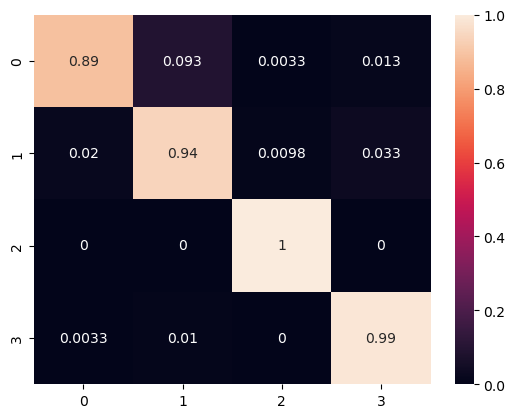

In [46]:
# let's check overall accuracy
print('Accuracy : ', metrics.accuracy_score(y_test_labels, prediction))

# Confusion Matrics : Verify accuracy of each class
cm = confusion_matrix(y_test_labels, prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)

<AxesSubplot:>

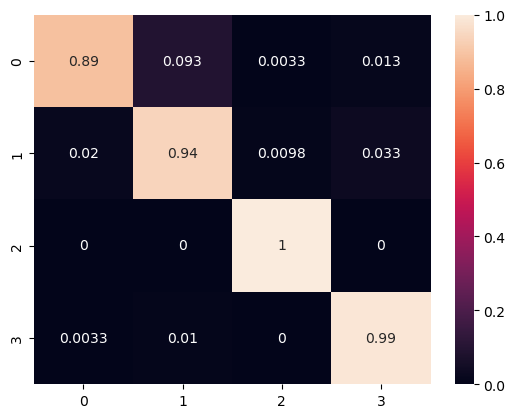

In [20]:
from tensorflow.keras.models import save_model

# ... Your code ...
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Accuracy

# Load the VGG16 model
vgg_model = load_model('vgg_model.h5')

# Compile the model
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Accuracy()])

# ... Continue using the model for prediction or evaluation ...


# Save the VGG16 model
save_model(vgg_model, 'vgg_model.h5')




In [36]:
# Save the XGBoost classifier
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

In [51]:
import numpy as np
from PIL import Image
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
import joblib

# Load the saved models
inception_model = load_model('vgg_model.h5')
xgb_classifier = joblib.load('model.pkl')

# Load and preprocess the image
image_path = 'C:/Users/Arun/Downloads/dataset3/Testing/meningioma/Te-me_0012.jpg'
# img = Image.open(image_path).resize((128, 128))
# img = np.array(img)
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)
img = cv2.imread(image_path)  # Read the image using OpenCV
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (128, 128))  # Resize the image to match the input shape of the model
img = np.expand_dims(img, axis=0)  # Add an extra dimension to represent batch size
img = preprocess_input(img)
# img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)    # read color image 
# img = cv2.merge((img, img, img))      # we have grey scale image, here we are converting it into 3 channel image
# img = cv2.resize(img, (SIZE, SIZE))        # resize the image
# img = preprocess_input(img)      
# Extract features using InceptionV3
features = inception_model.predict(img)
features = np.reshape(features, (1, -1))  # Reshape to a 2-dimensional matrix

# Classify the image using XGBoost
class_label = xgb_classifier.predict(features)[0]

# Print the predicted class label
print("Predicted Class Label:", class_label)



1/1 [==============================] - 0s 130ms/step
Predicted Class Label: 2


In [49]:
def testing(image_path):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.merge((img, img, img))
#     img = cv2.resize(img, (SIZE, SIZE))
#     img = np.array([img])  # Reshape the image to match the input shape of the model
    img = Image.open(image_path).resize((128, 128))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    # Normalize the pixel values
#     img = img / 255.0
    features = inception_model.predict(img)
    features = np.reshape(features, (1, -1))  # Reshape to a 2-dimensional matrix

    return features

# Example usage
image_path = 'C:/Users/Arun/Downloads/dataset3/Testing/meningioma/Te-me_0012.jpg'  # Replace with the path to your image
test_image = testing(image_path)
prediction = model.predict(test_image)
print("Predicted Class Label:", prediction)

1/1 [==============================] - 0s 55ms/step
Predicted Class Label: [2]


In [56]:
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image

def testing(image_path):
    img = cv2.imread(image_path)  # Read the image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (128, 128))  # Resize the image to match the input shape of the model
    img = np.expand_dims(img, axis=0)  # Add an extra dimension to represent batch size
    img = preprocess_input(img)  # Preprocess the image

    features = vgg_model.predict(img)  # Extract features using VGG16
    features = np.reshape(features, (1, -1))  # Reshape to a 2-dimensional matrix

    return features

# Example usage
image_path = 'C:/Users/Arun/Downloads/dataset3/Testing/notumor/Te-no_0019.jpg'  # Replace with the path to your image
test_image = testing(image_path)
prediction = model.predict(test_image)
print("Predicted Class Label:", prediction)


1/1 [==============================] - 0s 48ms/step
Predicted Class Label: [2]


In [77]:
import numpy as np
from PIL import Image
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
import joblib

def predict_class(image) :
#     with st.spinner('Loading, please be patient...') :
        # model = joblib.load(r'E:\DHL Project\CNN Projects\Deep Hybrid Learning Projects\X-ray\xray.pkl')
    model = joblib.load('model.pkl')
    vggmodel = VGG16(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))
    for i in vggmodel.layers :
        i.trainable = False

    label = {0:'glioma', 1:'meningioma', 2:'notumor', 3:'pituitary'}


    test_image = image.resize((128, 128))
    test_image = np.array(test_image)
    test_image = preprocess_input(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    features = vggmodel.predict(test_image)
    features = features.reshape(features.shape[0], -1)
    prediction = model.predict(features)[0]
    final = label[prediction]
    return final

image_path = 'C:/Users/Arun/Downloads/dataset3/Testing/pituitary/Te-pi_0020.jpg'  # Replace with the path to your image
image = Image.open(image_path)
image = image.resize((128, 128))
result = predict_class(image)
print("Predicted Class Label:", result)


1/1 [==============================] - 0s 123ms/step
Predicted Class Label: pituitary


In [20]:
import pickle

# Save the model to a file
filename = 'model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Load the model from the file
loaded_model = pickle.load(open(filename, 'rb'))



In [48]:
# import cv2
# import numpy as np
# from keras.models import load_model


# # Load and preprocess the image
# image_path = 'C:/Users/Arun/Downloads/dataset3/Testing/glioma/Te-gl_0046.jpg'
# image = cv2.imread(image_path)
# image = cv2.resize(image, (1, 8192))  # Adjust the size as per the model's input requirements
# image = image / 255.0  # Normalize pixel values if required
# image = np.expand_dims(image, axis=0)  # Add batch dimension
# ab = vgg_model.predict(image)
# ab = ab.reshape(feature_extractor_test.shape[0], -1)
# # Perform the prediction
# predictions = loaded_model.predict(ab)
# #predicted_class = np.argmax(predictions)
# prediction1 = le.inverse_transform(predictions)
# # Print the predicted class
# print('Predicted class:', prediction1)


1/1 [==============================] - 0s 33ms/step


ValueError: Feature shape mismatch, expected: 8192, got 0

In [26]:
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [52]:
# Display label list
print("Label List:")
for label, index in labels.items():
    print(f"Class {index}: {label}")


Label List:
Class 0: glioma
Class 1: meningioma
Class 2: notumor
Class 3: pituitary


First 5 images and labels in training dataset:


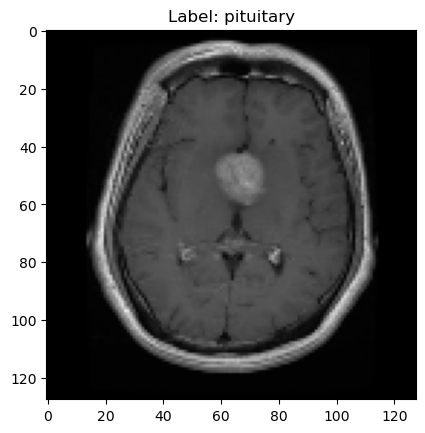

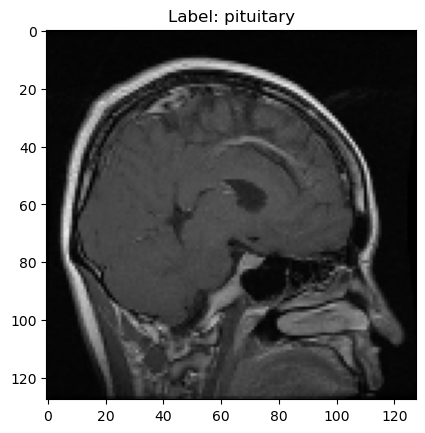

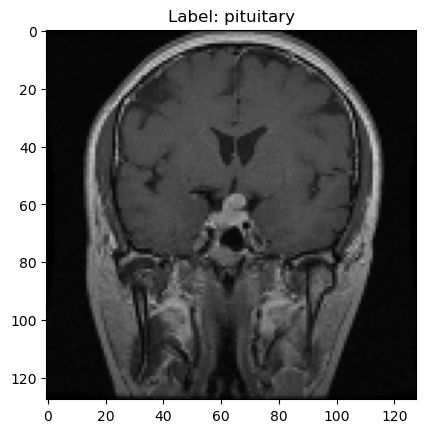

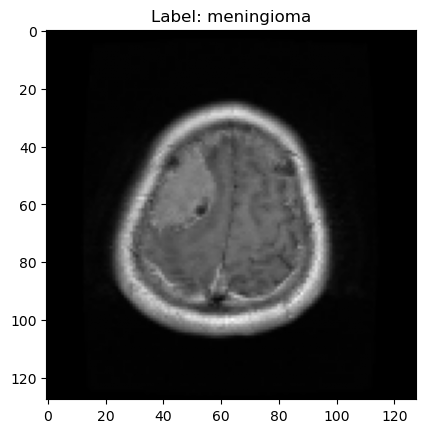

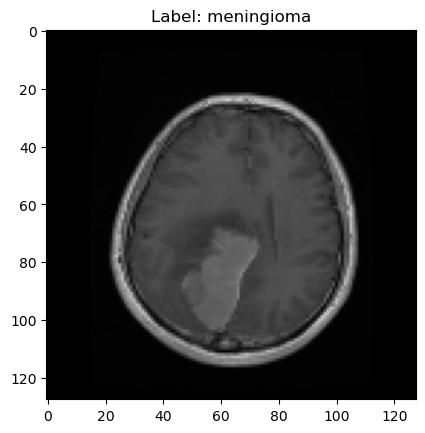

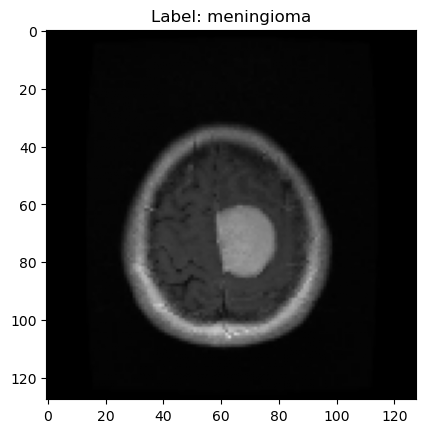

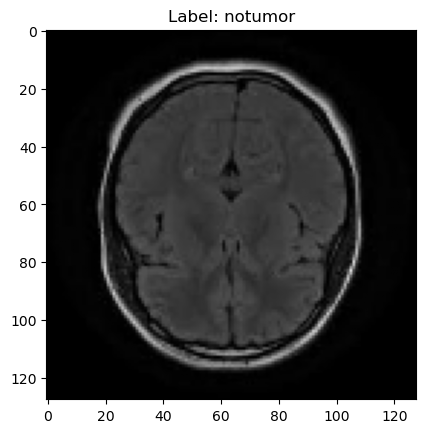

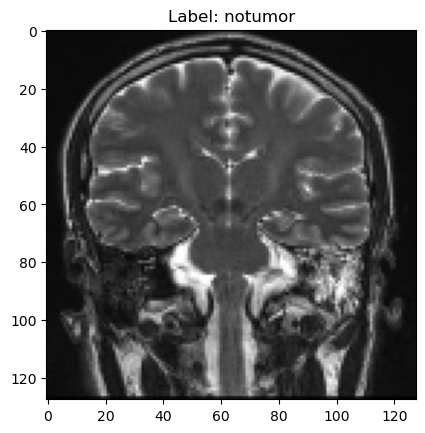

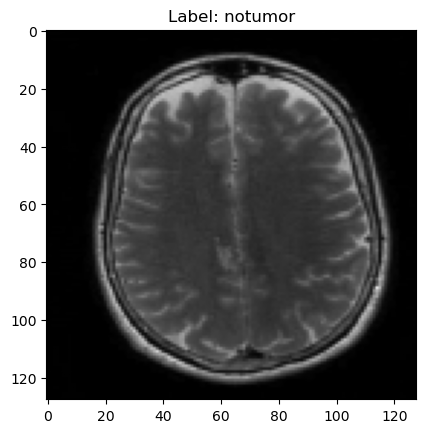

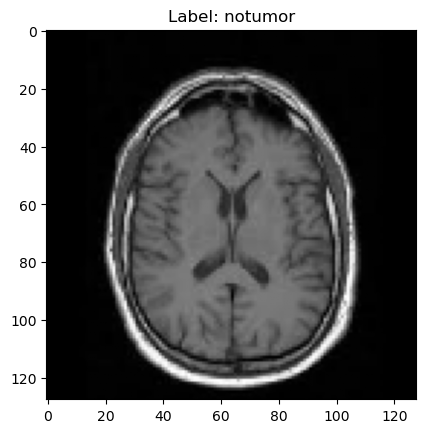

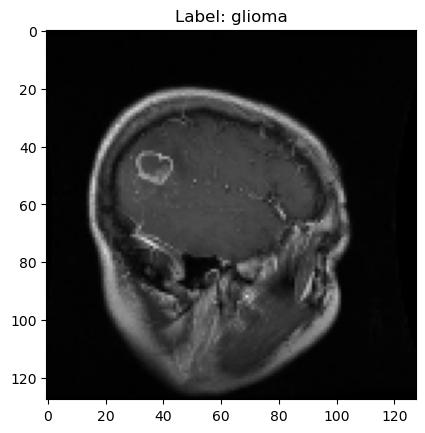

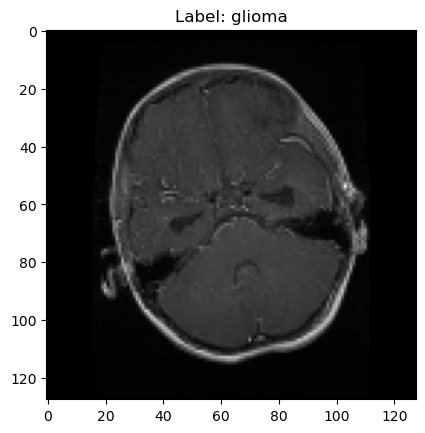

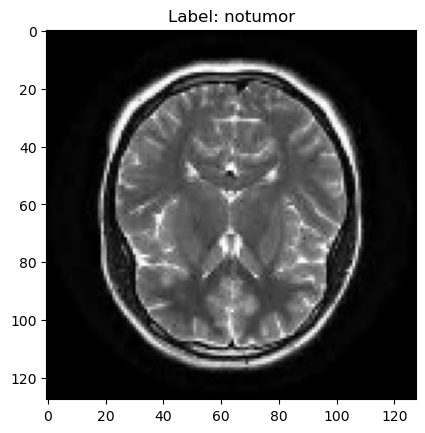

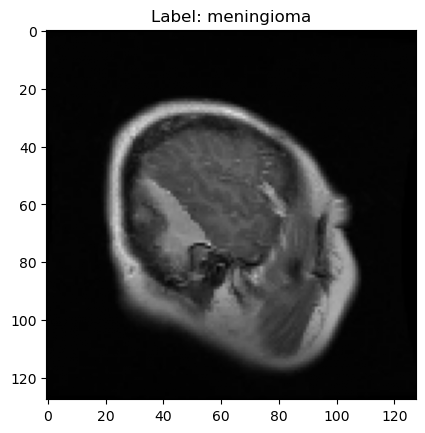

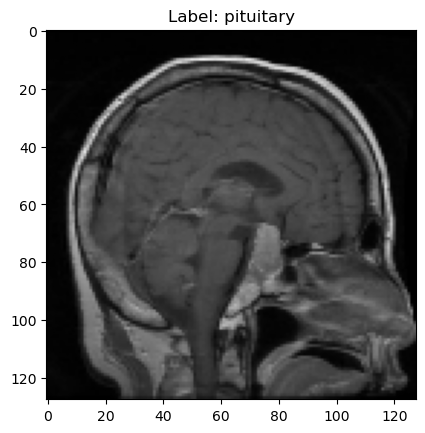

In [55]:
# Display first 5 images and labels in training dataset
print("First 5 images and labels in training dataset:")
for i in range(15):
    image = X_train[i]
    label = y_train_labels[i]
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt


In [24]:
# import cv2
# import os
# true_value = []
# pred = []
# i=0
# for folder in os.listdir(X_test):
#     i=0
#     test_image_ids = os.listdir(os.path.join(r,"C:\Users\Arun\Downloads\dataset3\Testing",folder))

#     for image_id in test_image_ids[:int(len(test_image_ids))]:

#         path = os.path.join(X_test,folder,image_id)

#         true_value.append(test_generator.class_indices[folder])
#         img = cv2.resize(cv2.imread(path),(150,150))
#         img_normalized = img/255

#         p = np.argmax(model.predict(np.array([img_normalized])))
#         pred.append(p)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2523143239.py, line 8)

In [42]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = true_value.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.9572845156369184


ValueError: Number of classes, 4, does not match size of target_names, 1311. Try specifying the labels parameter

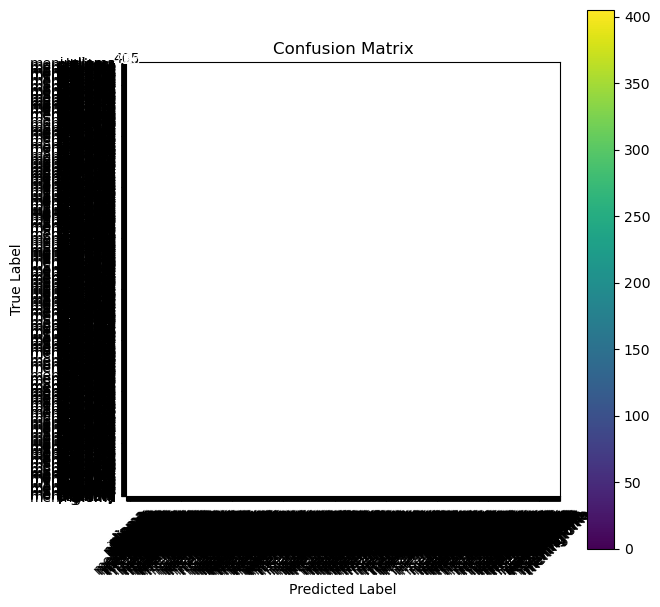

In [43]:
# # from sklearn.metrics import confusion_matrix, classification_report
# import itertools
# import matplotlib.pyplot as plt
# clf_report(y_test_labels, prediction)

In [45]:
print(classification_report(y_test_labels, prediction))

              precision    recall  f1-score   support

      glioma       0.97      0.89      0.93       300
  meningioma       0.90      0.94      0.92       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311

